In [1]:
!git clone https://github.com/angelo-volpe/document-generator-text-extractor.git

Cloning into 'document-generator-text-extractor'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 37 (delta 9), reused 35 (delta 7), pack-reused 0 (from 0)
Receiving objects: 100% (37/37), 2.65 MiB | 15.05 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [2]:
!pwd

/content


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!mkdir --parents /content/data/document_19

In [9]:
!cp /content/drive/MyDrive/Colab\ Data/document_19/20250410185834.zip /content/data/document_19/20250410185834.zip

In [10]:
!unzip /content/data/document_19/20250410185834.zip -d /content/data/document_19/

Archive:  /content/data/document_19/20250410185834.zip
   creating: /content/data/document_19/20250410185834/
   creating: /content/data/document_19/20250410185834/test/
  inflating: /content/data/document_19/20250410185834/test_labels.json  
  inflating: /content/data/document_19/20250410185834/test_labels.txt  
  inflating: /content/data/document_19/20250410185834/train_labels.json  
  inflating: /content/data/document_19/20250410185834/train_labels.txt  
   creating: /content/data/document_19/20250410185834/train/
  inflating: /content/data/document_19/20250410185834/test/sample_72.png  
  inflating: /content/data/document_19/20250410185834/test/sample_66.png  
  inflating: /content/data/document_19/20250410185834/test/sample_106.png  
  inflating: /content/data/document_19/20250410185834/test/sample_112.png  
  inflating: /content/data/document_19/20250410185834/test/sample_99.png  
  inflating: /content/data/document_19/20250410185834/test/sample_98.png  
  inflating: /content/dat

In [12]:
!rm /content/data/document_19/20250410185834.zip

rm: cannot remove '/content/data/document_19/20250410185834.zip': No such file or directory


In [13]:
import sys
import os
from matplotlib import pyplot as plt
from torchvision import transforms
from pathlib import Path
from PIL import Image
import torch
import numpy as np
import matplotlib.patches as patches
from torch.utils.data import DataLoader

In [14]:
sys.path.append(os.path.abspath("/content/document-generator-text-extractor/src/text_detector_model"))

In [15]:
from dataset import DocumentDataset
from train import train_model
from model import get_faster_rcnn_model

In [16]:
# import torch_xla.core.xla_model as xm
# import torch_xla.distributed.parallel_loader as pl

In [17]:
data_version = "20250410185834"
batch_size = 16
device = device = torch.device("cuda") # torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu")

# Define transformations for input images
transform = transforms.Compose([
    transforms.Resize((724, 512)),
    transforms.ToTensor()
])

# Load data
documents_dir = Path(f"/content/data/document_19/{data_version}/")

In [18]:
train_dataset = DocumentDataset(images_dir=documents_dir / "train", annotation_file=documents_dir / "train_labels.json", transform=transform)
test_val_dataset = DocumentDataset(images_dir=documents_dir / "test", annotation_file=documents_dir / "test_labels.json", transform=transform)

# Split into val/test
val_size = int(0.5 * len(test_val_dataset))
test_size = len(test_val_dataset) - val_size

val_dataset, test_dataset = torch.utils.data.random_split(
    test_val_dataset, [val_size, test_size]
)

def collate_fn(batch):
    return tuple(zip(*batch))

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False, num_workers=0, collate_fn=collate_fn)

In [19]:
# train_tpu_loader = pl.ParallelLoader(train_loader, [device]).per_device_loader(device)

In [20]:
img = train_dataset[0][0]
label = train_dataset[0][1]

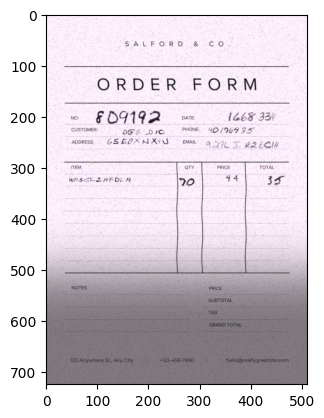

In [21]:
plt.imshow(img.numpy().transpose(1, 2, 0))
plt.show()

In [22]:
label

{'boxes': tensor([[  97.,  705.,  372.,  728.],
         [ 785.,  422., 1004.,  464.],
         [ 570.,  706.,  643.,  745.],
         [ 950.,  696., 1047.,  741.],
         [ 212.,  414.,  507.,  476.],
         [ 326.,  497.,  525.,  523.],
         [ 699.,  488.,  904.,  517.],
         [ 773.,  693.,  830.,  726.],
         [ 688.,  548., 1004.,  581.],
         [ 261.,  535.,  539.,  564.]]),
 'labels': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])}

In [23]:
# Initialize model
model = get_faster_rcnn_model(len(train_dataset.classes) + 1)
model.to(device)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 164MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [24]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

In [25]:
trained_model = train_model(model, train_loader, optimizer, device, num_epochs=1)

Epoch 1/1
Loss: 17.5641


In [26]:
trained_model = train_model(trained_model, train_loader, optimizer, device, num_epochs=50)

Epoch 1/50
Loss: 9.2163
Epoch 2/50
Loss: 7.1405
Epoch 3/50
Loss: 4.3181
Epoch 4/50
Loss: 3.7790
Epoch 5/50
Loss: 4.1521
Epoch 6/50
Loss: 3.4014
Epoch 7/50
Loss: 3.4796
Epoch 8/50
Loss: 3.3840
Epoch 9/50
Loss: 3.4025
Epoch 10/50
Loss: 3.3613
Epoch 11/50
Loss: 3.4325
Epoch 12/50
Loss: 3.3841
Epoch 13/50
Loss: 3.2698
Epoch 14/50
Loss: 3.2004
Epoch 15/50
Loss: 3.1949
Epoch 16/50
Loss: 3.4897
Epoch 17/50
Loss: 3.3301
Epoch 18/50
Loss: 3.3636
Epoch 19/50
Loss: 3.3253
Epoch 20/50
Loss: 3.2325
Epoch 21/50
Loss: 3.1112
Epoch 22/50
Loss: 3.1994
Epoch 23/50
Loss: 3.1557
Epoch 24/50
Loss: 3.2278
Epoch 25/50
Loss: 3.1829
Epoch 26/50
Loss: 3.1711
Epoch 27/50
Loss: 3.1291
Epoch 28/50
Loss: 3.1603
Epoch 29/50
Loss: 3.0812
Epoch 30/50
Loss: 3.1232
Epoch 31/50
Loss: 3.0261
Epoch 32/50
Loss: 3.0910
Epoch 33/50
Loss: 3.1212
Epoch 34/50
Loss: 3.1174
Epoch 35/50
Loss: 3.0544
Epoch 36/50
Loss: 3.0667
Epoch 37/50
Loss: 2.9824
Epoch 38/50
Loss: 3.0202
Epoch 39/50
Loss: 2.9842
Epoch 40/50
Loss: 3.0462
Epoch 41/

In [ ]:
# Save model
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Data/faster_rcnn_document_19.pth')

In [ ]:
# TODO check validation loss while training
# TODO Save model to mlflow

In [ ]:
def process_document(model, image, device, confidence_threshold=0.7):
    """
    Process a new document using the trained model

    Args:
        model: Trained Faster R-CNN model
        image: image RGB
        device: Device to run the model on
        confidence_threshold: Threshold for confidence scores

    Returns:
        Dictionary mapping field types to extracted text
    """
    # Load the image
    original_image = np.array(image)

    # Transform image
    #transform = transforms.Compose([
    #    transforms.ToTensor()
    #])
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Set model to evaluation mode
    model.eval()

    # Get predictions
    with torch.no_grad():
        prediction = model(image_tensor)[0]

    # Get boxes, labels, and scores
    boxes = prediction['boxes'].cpu().numpy()
    labels = prediction['labels'].cpu().numpy()
    scores = prediction['scores'].cpu().numpy()

    print(f"Boxes: {boxes}")
    print(f"Scores: {scores}")

    # Filter by confidence threshold
    mask = scores >= confidence_threshold
    boxes = boxes[mask]
    labels = labels[mask]
    scores = scores[mask]

    # Save image with predicted bounding boxes for visualization
    plt.figure(figsize=(12, 12))
    plt.imshow(original_image)
    ax = plt.gca()

    for box, label, score in zip(boxes, labels, scores):
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2,
                                 edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(x1, y1, f"{label}: {score:.2f}",
                 fontsize=12, bbox=dict(facecolor='white', alpha=0.7))

    os.makedirs("results", exist_ok=True)
    plt.show()

    return

In [ ]:
image = Image.open(documents_dir / "train" / "sample_3.png").convert("RGB")

Boxes: [[244.21788  485.56467  512.       522.94934 ]
 [169.41898  425.98682  394.08167  474.7007  ]
 [164.512    697.33887  509.64246  724.      ]
 [214.71027  415.55356  484.30682  449.3447  ]
 [160.3458   394.28293  510.2664   476.50992 ]
 [216.16539  484.77823  512.       512.6282  ]
 [125.715416 692.23676  365.43393  724.      ]]
Scores: [0.60325414 0.22572023 0.21440312 0.14076698 0.09935515 0.07482354
 0.06959166]


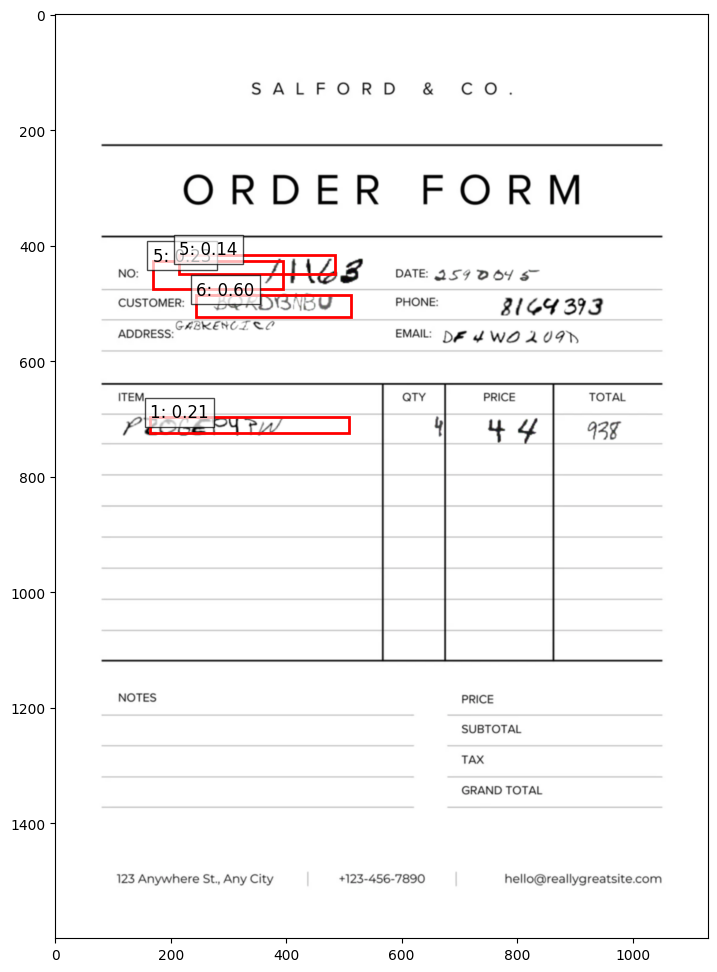

In [ ]:
process_document(trained_model, image, device, confidence_threshold=0.1)

In [ ]:
train_dataset.classes

{'Item 1': 1,
 'Date': 2,
 'Quantity 1': 3,
 'Total 1': 4,
 'Number': 5,
 'Customer': 6,
 'Phone': 7,
 'Price 1': 8,
 'Email': 9,
 'Address': 10}

## Real Image

In [ ]:
import cv2

In [ ]:
def align_to_template(image, template):
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

    orb = cv2.SIFT_create(500)
    keypoints1, descriptors1 = orb.detectAndCompute(image_gray, None)
    keypoints2, descriptors2 = orb.detectAndCompute(template_gray, None)

    # Match features.
    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_SL2)
    matches = matcher.match(descriptors1, descriptors2, None)

    # Sort matches by score
    matches = sorted(matches, key=lambda x: x.distance, reverse=False)

    # Remove not so good matches
    num_good_matches = int(len(matches) * 0.15)
    matches = matches[:num_good_matches]

    # Extract location of good matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)

    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt

    # Find homography
    h, _ = cv2.findHomography(points1, points2, cv2.RANSAC)

    # Use homography
    height, width = template_gray.shape
    registered_image = cv2.warpPerspective(image, h, (width, height))

    return registered_image

In [ ]:
image = cv2.imread("/Users/volpea/Documents/projects/document-generator-job/data/test/example_form_real_1.jpg")
template = cv2.imread("/Users/volpea/Documents/projects/document-generator-text-extractor/data/templates/example_form_template.webp")

In [ ]:
registered_image = align_to_template(image, template)
registered_image = Image.fromarray(cv2.cvtColor(registered_image, cv2.COLOR_BGR2RGB))

Boxes: [[169.09181 423.00815 396.01724 471.89005]
 [135.87231 696.9215  497.735   724.     ]
 [218.10199 415.99078 484.87253 450.4562 ]
 [266.98074 426.43365 504.8358  460.27475]
 [148.8178  389.08026 512.      476.36453]]
Scores: [0.18327433 0.1273529  0.1012964  0.08460017 0.06198521]


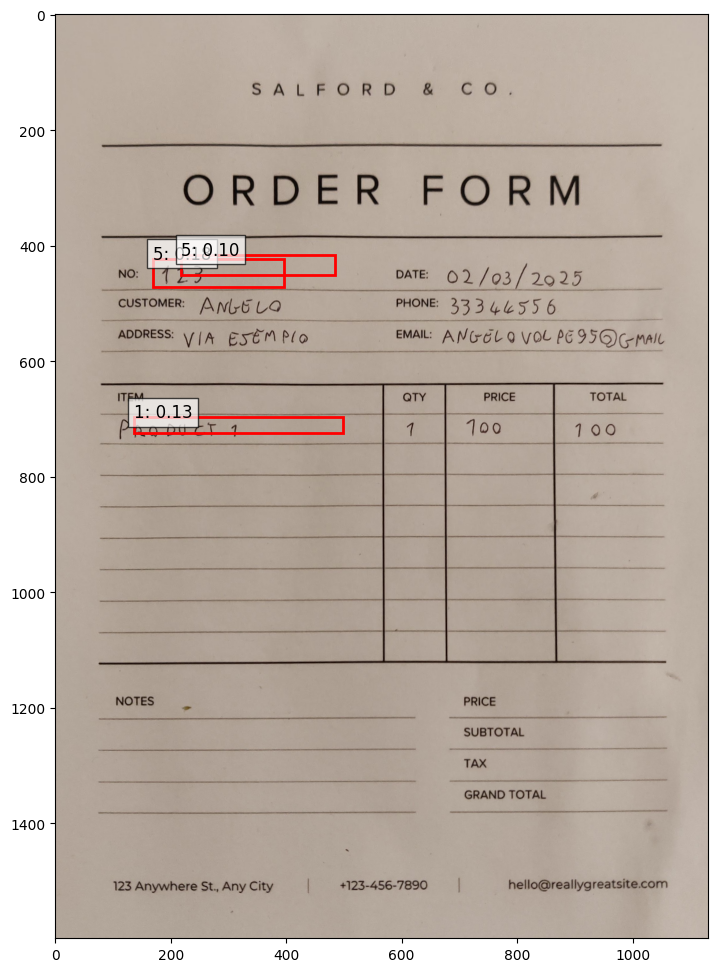

In [ ]:
process_document(trained_model, registered_image, device, confidence_threshold=0.1)